# Exploration of non-spatial associations through LTP-IE

N_B_S =  200
N_M_B =  200
W_B_S =  0.8800000000000001
W_M_B =  2.3333333333333335
W_M_M =  0.35


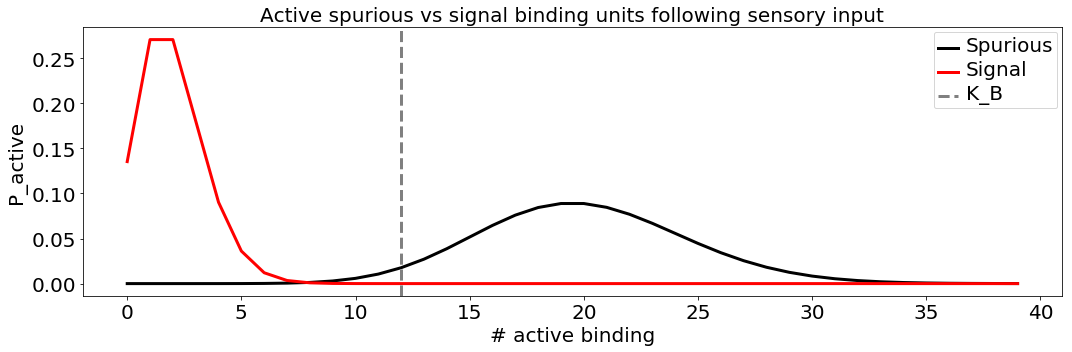

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from ntwk import SimpleNtwk, join_w

V_TH = 10  # atvn threshold
INP_G = 3  # gating input (2*I_G = baseline for LTP-IE-tagged cell)
MAX_ACTIVE = 50  # max num active nrns
RP = 5  # refractory period

N_SM = 100  # sensory or motor pool size
N_B = 2000  # binding pool size
N = 4*N_SM + N_B  # total neurons
N_B_S = int(np.round(N_B/10))  # num binding receiving cxns from one sensory pool
N_M_B = int(np.round(N_B/10))  # num binding sending cxns to one motor pool
N_B_S_W = 10  # num cxns from sensory pool to indiv binding unit
W_B_S = 1.1 * (N_SM / MAX_ACTIVE) * (V_TH - (2*INP_G)) / N_B_S_W

K_B = 12  # crossover point separating signal from spurious activated LTP-IE-tagged B units

N_M_B_W = 25  # num cxns from indiv binding unit to motor pool
W_M_B = ((V_TH - INP_G) / K_B) * N_SM / N_M_B_W
W_M_M = (V_TH - INP_G) / (N_SM/5)

print('N_B_S = ', N_B_S)
print('N_M_B = ', N_M_B)
print('W_B_S = ', W_B_S)
print('W_M_B = ', W_M_B)
print('W_M_M = ', W_M_M)

fig, ax = plt.subplots(1, 1, figsize=(15, 5), tight_layout=True)
k = np.arange(0, 40)
p_0 = stats.poisson.pmf(k, N_B*(N_B_S/N_B)*(N_M_B/N_B))
p_1 = stats.poisson.pmf(k, N_B*(N_B_S/N_B)*(N_M_B/N_B)*(N_M_B/N_B))

ax.plot(k, p_0, color='k', lw=3)
ax.plot(k, p_1, color='r', lw=3)
ax.axvline(K_B, color='gray', lw=3, ls='--')
ax.set_xlabel('# active binding')
ax.set_ylabel('P_active')
ax.set_title('Active spurious vs signal binding units following sensory input')
ax.legend(['Spurious', 'Signal', 'K_B'])

set_font_size(ax, 20)

In [2]:
# define useful slice objects
slice_s_1 = slice(0, N_SM)
slice_s_2 = slice(N_SM, 2*N_SM)
slice_m_1 = slice(2*N_SM, 3*N_SM)
slice_m_2 = slice(3*N_SM, 4*N_SM)
slice_b = slice(4*N_SM, N)

In [3]:
def make_ntwk(seed, assoc):
    """Build model binding pool network."""
    np.random.seed(seed)
    
    # set up binding pool
    
    ## get binding units receiving S1 and S2 input
    b_idxs_s_1 = np.random.permutation(N_B)[:N_B_S]
    b_idxs_s_2 = np.random.permutation(N_B)[:N_B_S]
    
    ## get binding units sending output to M1 and M2
    b_idxs_m_1 = np.random.permutation(N_B)[:N_M_B]
    b_idxs_m_2 = np.random.permutation(N_B)[:N_M_B]
    
    ## get all overlap profiles
    b_idxs_s_1_m_1 = list(set(b_idxs_s_1).intersection(b_idxs_m_1))
    b_idxs_s_1_m_2 = list(set(b_idxs_s_1).intersection(b_idxs_m_2))
    b_idxs_s_2_m_1 = list(set(b_idxs_s_2).intersection(b_idxs_m_1))
    b_idxs_s_2_m_2 = list(set(b_idxs_s_2).intersection(b_idxs_m_2))
    
    b_idxs_s_1_m_1_m_2 = list(set(b_idxs_s_1_m_1).intersection(b_idxs_m_2))
    b_idxs_s_2_m_2_m_1 = list(set(b_idxs_s_2_m_2).intersection(b_idxs_m_1))
    b_idxs_s_1_m_2_m_1 = list(set(b_idxs_s_1_m_2).intersection(b_idxs_m_1))
    b_idxs_s_2_m_1_m_2 = list(set(b_idxs_s_2_m_1).intersection(b_idxs_m_2))
    
    ## make binding pool LTP-IE profile
    if assoc == 'S1->M1,S2->M2':
        idxs_ltp_ie = list(set(b_idxs_s_1_m_1).union(b_idxs_s_2_m_2))
    elif assoc == 'S1->M2,S2->M1':
        idxs_ltp_ie = list(set(b_idxs_s_1_m_2).union(b_idxs_s_2_m_1))
        
    # build full connections
    ## N_B_S_W rand cxns from S_1 to each B unit connected to S_1
    w_b_s_1 = np.zeros((N_B, N_SM))
    for row in b_idxs_s_1:
        w_b_s_1[row, :][np.random.permutation(N_SM)[:N_B_S_W]] = W_B_S
        
    ## N_B_S_W rand cxns from S_2 to each B unit connected to S_2
    w_b_s_2 = np.zeros((N_B, N_SM))
    for row in b_idxs_s_2:
        w_b_s_2[row, :][np.random.permutation(N_SM)[:N_B_S_W]] = W_B_S
    
    ## N_M_B_W rand cxns to M_1 from each B unit connected to M_1
    w_m_1_b = np.zeros((N_SM, N_B))
    for col in b_idxs_m_1:
        w_m_1_b[:, col][np.random.permutation(N_SM)[:N_M_B_W]] = W_M_B
        
    ## N_M_B_W rand cxns to M_2 from each B unit connected to M_2
    w_m_2_b = np.zeros((N_SM, N_B))
    for col in b_idxs_m_2:
        w_m_2_b[:, col][np.random.permutation(N_SM)[:N_M_B_W]] = W_M_B
    
    ## fully connected motor pools
    w_m_1_m_1 = np.ones((N_SM, N_SM)) * W_M_M
    w_m_2_m_2 = np.ones((N_SM, N_SM)) * W_M_M
    
    slice_s_1 = slice(0, N_SM)
    slice_s_2 = slice(N_SM, 2*N_SM)
    slice_m_1 = slice(2*N_SM, 3*N_SM)
    slice_m_2 = slice(3*N_SM, 4*N_SM)
    slice_b = slice(4*N_SM, N)
    
    w = np.zeros((N, N))
    
    w[slice_b, slice_s_1] = w_b_s_1
    w[slice_b, slice_s_2] = w_b_s_2
    w[slice_m_1, slice_b] = w_m_1_b
    w[slice_m_2, slice_b] = w_m_2_b
    w[slice_m_1, slice_m_1] = w_m_1_m_1
    w[slice_m_2, slice_m_2] = w_m_2_m_2
    
    # make full LTP-IE profile
    ltp_ie = np.zeros(N, dtype=float)
    ltp_ie[-N_B:][idxs_ltp_ie] = 1
    
    ntwk = SimpleNtwk(w, ltp_ie, MAX_ACTIVE, V_TH, RP)
    
    info = {
        'b_idxs_s_1': b_idxs_s_1,  # should be ~q
        'b_idxs_s_2': b_idxs_s_2,  # should be ~q
        
        'b_idxs_m_1': b_idxs_m_1,  # should be ~q
        'b_idxs_m_2': b_idxs_m_2,  # should be ~q
        
        'b_idxs_s_1_m_1': b_idxs_s_1_m_1,  # should be ~q**2
        'b_idxs_s_1_m_2': b_idxs_s_1_m_2,  # should be ~q**2
        'b_idxs_s_2_m_1': b_idxs_s_2_m_1,  # should be ~q**2
        'b_idxs_s_2_m_2': b_idxs_s_2_m_2,  # should be ~q**2
        
        'b_idxs_s_1_m_1_m_2': b_idxs_s_1_m_1_m_2,  # should be ~q**3
        'b_idxs_s_2_m_2_m_1': b_idxs_s_2_m_2_m_1,  # should be ~q**3
        'b_idxs_s_1_m_2_m_1': b_idxs_s_1_m_2_m_1,  # should be ~q**3
        'b_idxs_s_2_m_1_m_2': b_idxs_s_2_m_1_m_2,  # should be ~q**3
        
        'w_b_s_1': w_b_s_1,
        'w_b_s_2': w_b_s_2,
        'w_m_1_b': w_m_1_b,
        'w_m_2_b': w_m_2_b,
        'w_m_1_m_1': w_m_1_m_1,
        'w_m_2_m_2': w_m_2_m_2,
        'w': w,
    }
    
    # set up positions for display purposes
    x_all = []
    y_all = []
    c_all = []
    
    # S1
    x = []
    y = []
    while True:
        x_, y_ = np.random.uniform(-1, 1, 2)
        if x_**2 + y_**2 <= 1:
            x.append(x_*.5 - 1.5)
            y.append(y_*.5 + 1.5)
            
        if len(x) == len(y) == N_SM:
            break
    
    x_all.extend(x)
    y_all.extend(y)
    c_all.extend(N_SM * ['m'])
    
    # S2
    x = []
    y = []
    while True:
        x_, y_ = np.random.uniform(-1, 1, 2)
        if x_**2 + y_**2 <= 1:
            x.append(x_*.5 - 1.5)
            y.append(y_*.5 - 1.5)
            
        if len(x) == len(y) == N_SM:
            break
    
    x_all.extend(x)
    y_all.extend(y)
    c_all.extend(N_SM * ['c'])
    
    # M1
    x = []
    y = []
    while True:
        x_, y_ = np.random.uniform(-1, 1, 2)
        if x_**2 + y_**2 <= 1:
            x.append(x_*.5 + 1.5)
            y.append(y_*.5 + 1.5)
            
        if len(x) == len(y) == N_SM:
            break
    
    x_all.extend(x)
    y_all.extend(y)
    c_all.extend(N_SM * ['r'])
    
    # M2
    x = []
    y = []
    while True:
        x_, y_ = np.random.uniform(-1, 1, 2)
        if x_**2 + y_**2 <= 1:
            x.append(x_*.5 + 1.5)
            y.append(y_*.5 - 1.5)
            
        if len(x) == len(y) == N_SM:
            break
    
    x_all.extend(x)
    y_all.extend(y)
    c_all.extend(N_SM * ['b'])
    
    # B
    x = []
    y = []
    while True:
        x_, y_ = np.random.uniform(-1, 1, 2)
        if x_**2 + y_**2 <= 1:
            x.append(x_)
            y.append(y_)
            
        if len(x) == len(y) == N_B:
            break
    
    x_all.extend(x)
    y_all.extend(y)
    c_all.extend(N_B * ['k'])
    
    assert len(x_all) == len(y_all) == N
    
    ntwk.x = np.array(x_all)
    ntwk.y = np.array(y_all)
    ntwk.c = np.array(c_all)
        
    return ntwk, info

# Run simulations

In [4]:
SEED = 0

# make ntwks
ntwk_a, info_a = make_ntwk(SEED, 'S1->M1,S2->M2')
ntwk_b, info_b = make_ntwk(SEED, 'S1->M2,S2->M1')

# build stimulation protocol
t = np.arange(5)
inp_ext_s_1 = np.zeros((len(t), N))  # S1 stim
inp_ext_s_1[1, slice_s_1] = V_TH - INP_G + 1

inp_ext_s_2 = np.zeros((len(t), N))  # S2 stim
inp_ext_s_2[1, slice_s_2] = V_TH - INP_G + 1

# drive each ntwk w each stim
rslt_a_s_1 = ntwk_a.run(inp_ext_s_1, INP_G)
rslt_a_s_2 = ntwk_a.run(inp_ext_s_2, INP_G)

rslt_b_s_1 = ntwk_b.run(inp_ext_s_1, INP_G)
rslt_b_s_2 = ntwk_b.run(inp_ext_s_2, INP_G)

for label, rslt in zip(['a_s_1', 'a_s_2', 'b_s_1', 'b_s_2'], [rslt_a_s_1, rslt_a_s_2, rslt_b_s_1, rslt_b_s_2]):
    print('rslt_{}'.format(label))
    for t_ in t:
        print('# spks @ t {}:'.format(t_), rslt.spks[t_].sum())

rslt_a_s_1
# spks @ t 0: 0
# spks @ t 1: 50
# spks @ t 2: 29
# spks @ t 3: 50
# spks @ t 4: 50
rslt_a_s_2
# spks @ t 0: 0
# spks @ t 1: 50
# spks @ t 2: 19
# spks @ t 3: 38
# spks @ t 4: 50
rslt_b_s_1
# spks @ t 0: 0
# spks @ t 1: 50
# spks @ t 2: 20
# spks @ t 3: 50
# spks @ t 4: 50
rslt_b_s_2
# spks @ t 0: 0
# spks @ t 1: 50
# spks @ t 2: 21
# spks @ t 3: 50
# spks @ t 4: 50


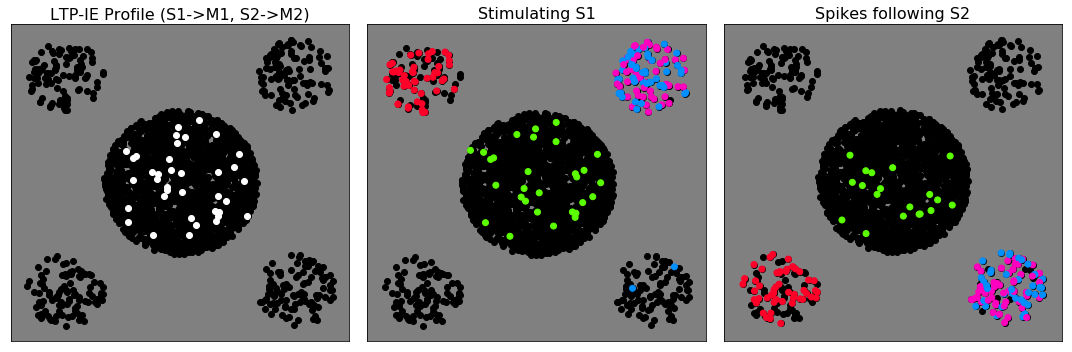

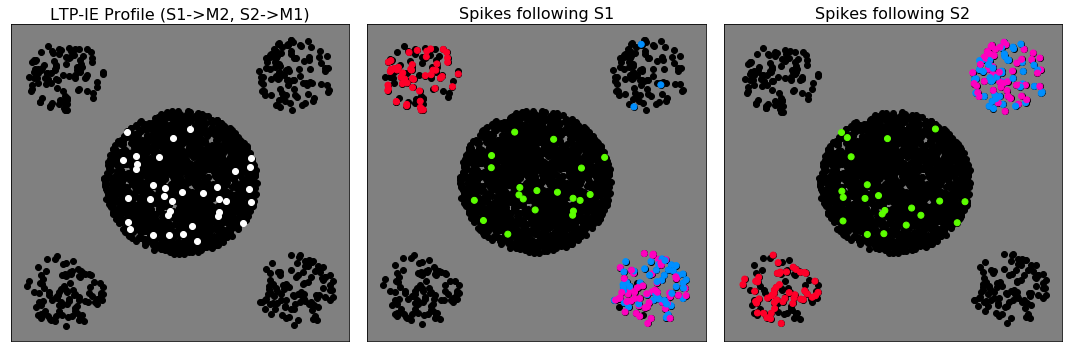

In [5]:
# make figures
## ntwk a
ntwk = ntwk_a
fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)

### LTP-IE profile
axs[0].set_title('LTP-IE Profile (S1->M1, S2->M2)')

axs[0].scatter(ntwk.x[~ntwk.ltp_ie.astype(bool)], ntwk.y[~ntwk.ltp_ie.astype(bool)], c='k', zorder=0)
axs[0].scatter(ntwk.x[ntwk.ltp_ie.astype(bool)], ntwk.y[ntwk.ltp_ie.astype(bool)], c='w', zorder=2)

### stimulating S1
axs[1].scatter(ntwk.x, ntwk.y, c='k', zorder=0)
idxs_active = rslt_a_s_1.spks.sum(axis=0) > 0  # mask of all active nrns
spks_active = rslt_a_s_1.spks[:, idxs_active]
t_first_spks = np.argmax(spks_active, axis=0) - 1
c = t_first_spks / 4

axs[1].scatter(ntwk.x[idxs_active], ntwk.y[idxs_active], c=c, cmap='gist_rainbow')
axs[1].set_title('Stimulating S1')

### stimulating S2
axs[2].scatter(ntwk.x, ntwk.y, c='k', zorder=0)
idxs_active = rslt_a_s_2.spks.sum(axis=0) > 0  # mask of all active nrns
spks_active = rslt_a_s_2.spks[:, idxs_active]
t_first_spks = np.argmax(spks_active, axis=0) - 1
c = t_first_spks / 4

axs[2].scatter(ntwk.x[idxs_active], ntwk.y[idxs_active], c=c, cmap='gist_rainbow')
axs[2].set_title('Spikes following S1')

axs[2].set_title('Spikes following S2')

for ax in axs:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_facecolor((.5, .5, .5))
    set_font_size(ax, 16)
    
## ntwk b
ntwk = ntwk_b
fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)

### LTP-IE profile
axs[0].set_title('LTP-IE Profile (S1->M2, S2->M1)')

axs[0].scatter(ntwk.x[~ntwk.ltp_ie.astype(bool)], ntwk.y[~ntwk.ltp_ie.astype(bool)], c='k', zorder=0)
axs[0].scatter(ntwk.x[ntwk.ltp_ie.astype(bool)], ntwk.y[ntwk.ltp_ie.astype(bool)], c='w', zorder=2)

### stimulating S1
axs[1].scatter(ntwk.x, ntwk.y, c='k', zorder=0)
idxs_active = rslt_b_s_1.spks.sum(axis=0) > 0  # mask of all active nrns
spks_active = rslt_b_s_1.spks[:, idxs_active]
t_first_spks = np.argmax(spks_active, axis=0) - 1
c = t_first_spks / 4

axs[1].scatter(ntwk.x[idxs_active], ntwk.y[idxs_active], c=c, cmap='gist_rainbow')
axs[1].set_title('Spikes following S1')

### stimulating S2
axs[2].scatter(ntwk.x, ntwk.y, c='k', zorder=0)
idxs_active = rslt_b_s_2.spks.sum(axis=0) > 0  # mask of all active nrns
spks_active = rslt_b_s_2.spks[:, idxs_active]
t_first_spks = np.argmax(spks_active, axis=0) - 1
c = t_first_spks / 4

axs[2].scatter(ntwk.x[idxs_active], ntwk.y[idxs_active], c=c, cmap='gist_rainbow')
axs[2].set_title('Spikes following S2')

for ax in axs:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_facecolor((.5, .5, .5))
    set_font_size(ax, 16)

# Tests to check network for correct structure

In [6]:
seed = np.random.randint(0, 1000)
ntwk_a, info_a = make_ntwk(seed, 'S1->M1,S2->M2')
ntwk_b, info_b = make_ntwk(seed, 'S1->M2,S2->M1')

assert np.all(ntwk_a.w == ntwk_b.w)

for label, ntwk, info in zip(['a', 'b'], [ntwk_a, ntwk_b], [info_a, info_b]):
    print('ntwk {}'.format(label))
    
    # check connections
    w = info['w']
    n_b_s_1 = (w[slice_b, slice_s_1].sum(axis=1) > 0).sum()
    n_b_s_2 = (w[slice_b, slice_s_2].sum(axis=1) > 0).sum()
    print('N_B_S: Desired:', N_B_S, '; Actual:', n_b_s_1, n_b_s_2)
    
    n_b_s_1_w = sorted(np.unique(np.sum(w[slice_b, slice_s_1] > 0, axis=1)))
    n_b_s_2_w = sorted(np.unique(np.sum(w[slice_b, slice_s_2] > 0, axis=1)))
    print('N_B_S_W: Desired: [0, {}];'.format(N_B_S_W), 'Actual:', n_b_s_1_w, n_b_s_2_w)
    print('')
    
    n_m_1_b = (w[slice_m_1, slice_b].sum(axis=0) > 0).sum()
    n_m_2_b = (w[slice_m_2, slice_b].sum(axis=0) > 0).sum()
    print('N_M_B: Desired:', N_M_B, '; Actual:', n_m_1_b, n_m_2_b)
    
    n_m_1_b_w = sorted(np.unique(np.sum(w[slice_m_1, slice_b] > 0, axis=0)))
    n_m_2_b_w = sorted(np.unique(np.sum(w[slice_m_1, slice_b] > 0, axis=0)))
    print('N_M_B_W: Desired: [0, {}];'.format(N_M_B_W), 'Actual:', n_m_1_b_w, n_m_2_b_w)
    
    print('')

ntwk a
N_B_S: Desired: 200 ; Actual: 200 200
N_B_S_W: Desired: [0, 10]; Actual: [0, 10] [0, 10]

N_M_B: Desired: 200 ; Actual: 200 200
N_M_B_W: Desired: [0, 25]; Actual: [0, 25] [0, 25]

ntwk b
N_B_S: Desired: 200 ; Actual: 200 200
N_B_S_W: Desired: [0, 10]; Actual: [0, 10] [0, 10]

N_M_B: Desired: 200 ; Actual: 200 200
N_M_B_W: Desired: [0, 25]; Actual: [0, 25] [0, 25]



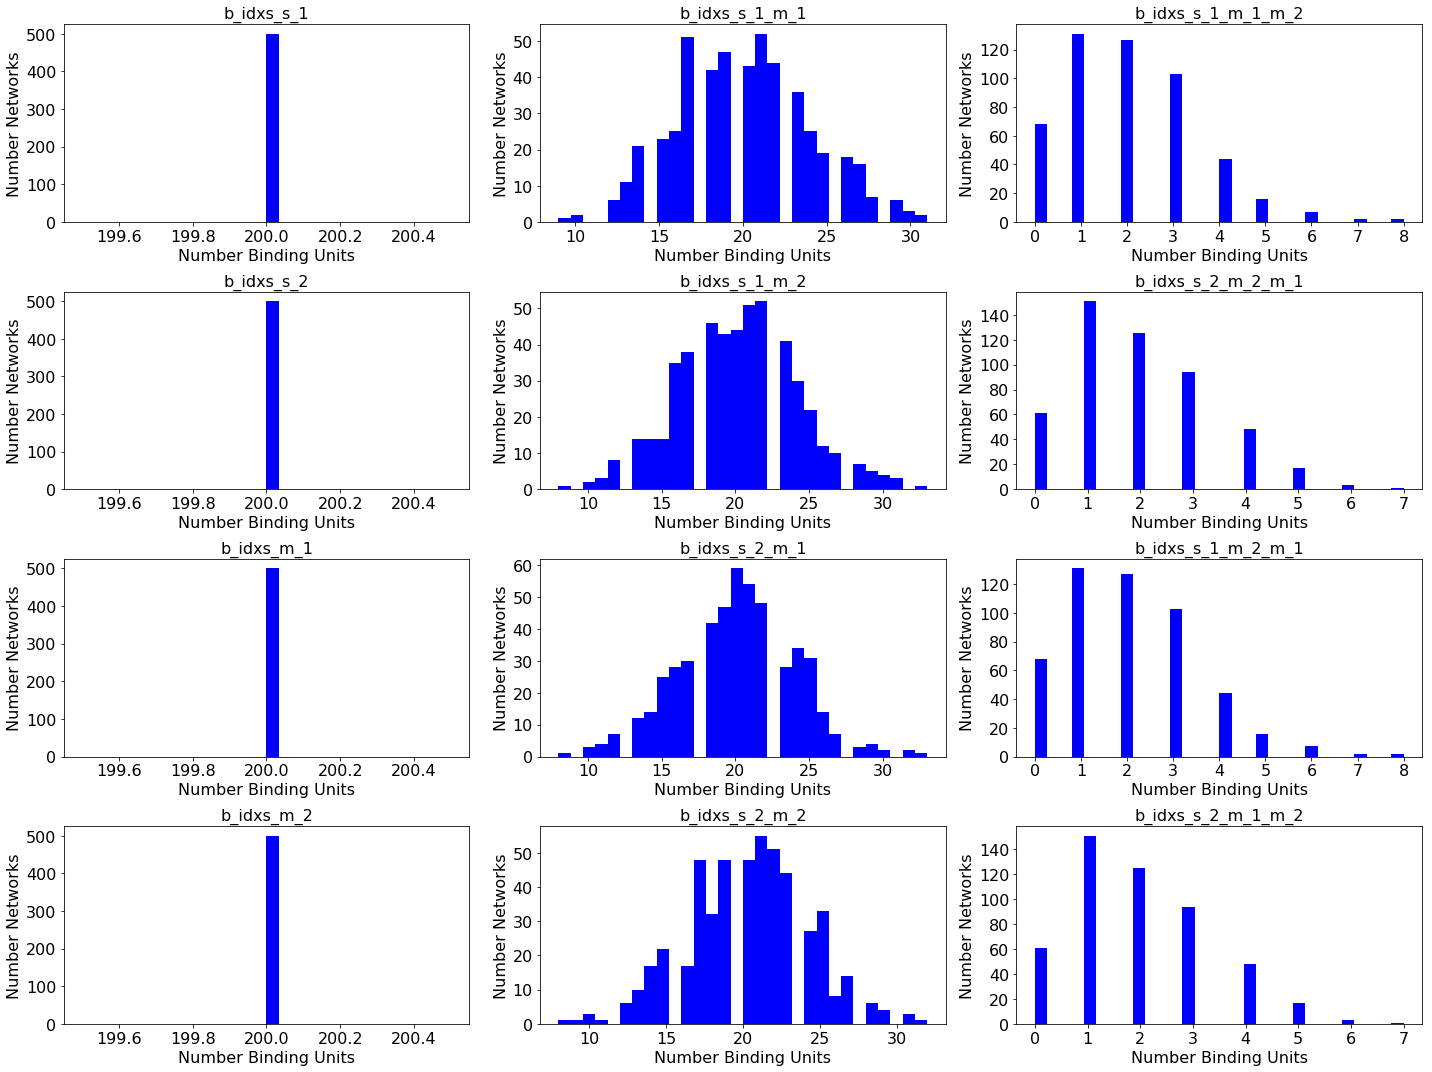

In [7]:
# loop over instantiations to get distribution of intersection sizes
b_idxs_sizes = {'n_{}'.format(k): [] for k in info if k.startswith('b_idx')}

for seed in range(500):
    # get size of intersections
    ntwk, info = make_ntwk(seed, 'S1->M1,S2->M2')
    for k in b_idxs_sizes:
        b_idxs_sizes[k].append(len(info[k[2:]]))
        
# plot histograms
order = [
    'b_idxs_s_1', 'b_idxs_s_2', 'b_idxs_m_1', 'b_idxs_m_2',  # should be ~Nq
    'b_idxs_s_1_m_1', 'b_idxs_s_1_m_2', 'b_idxs_s_2_m_1', 'b_idxs_s_2_m_2',  # should be ~Nq**2
    'b_idxs_s_1_m_1_m_2', 'b_idxs_s_2_m_2_m_1', 'b_idxs_s_1_m_2_m_1', 'b_idxs_s_2_m_1_m_2',  # should be ~Nq**3
]

fig, axs = plt.subplots(4, 3, figsize=(20, 15), tight_layout=True)
for k, ax in zip(order, axs.T.flatten()):
    ax.hist(b_idxs_sizes['n_{}'.format(k)], bins=30, color='b')
    ax.set_xlabel('Number Binding Units')
    ax.set_ylabel('Number Networks')
    ax.set_title(k)
    set_font_size(ax, 16)

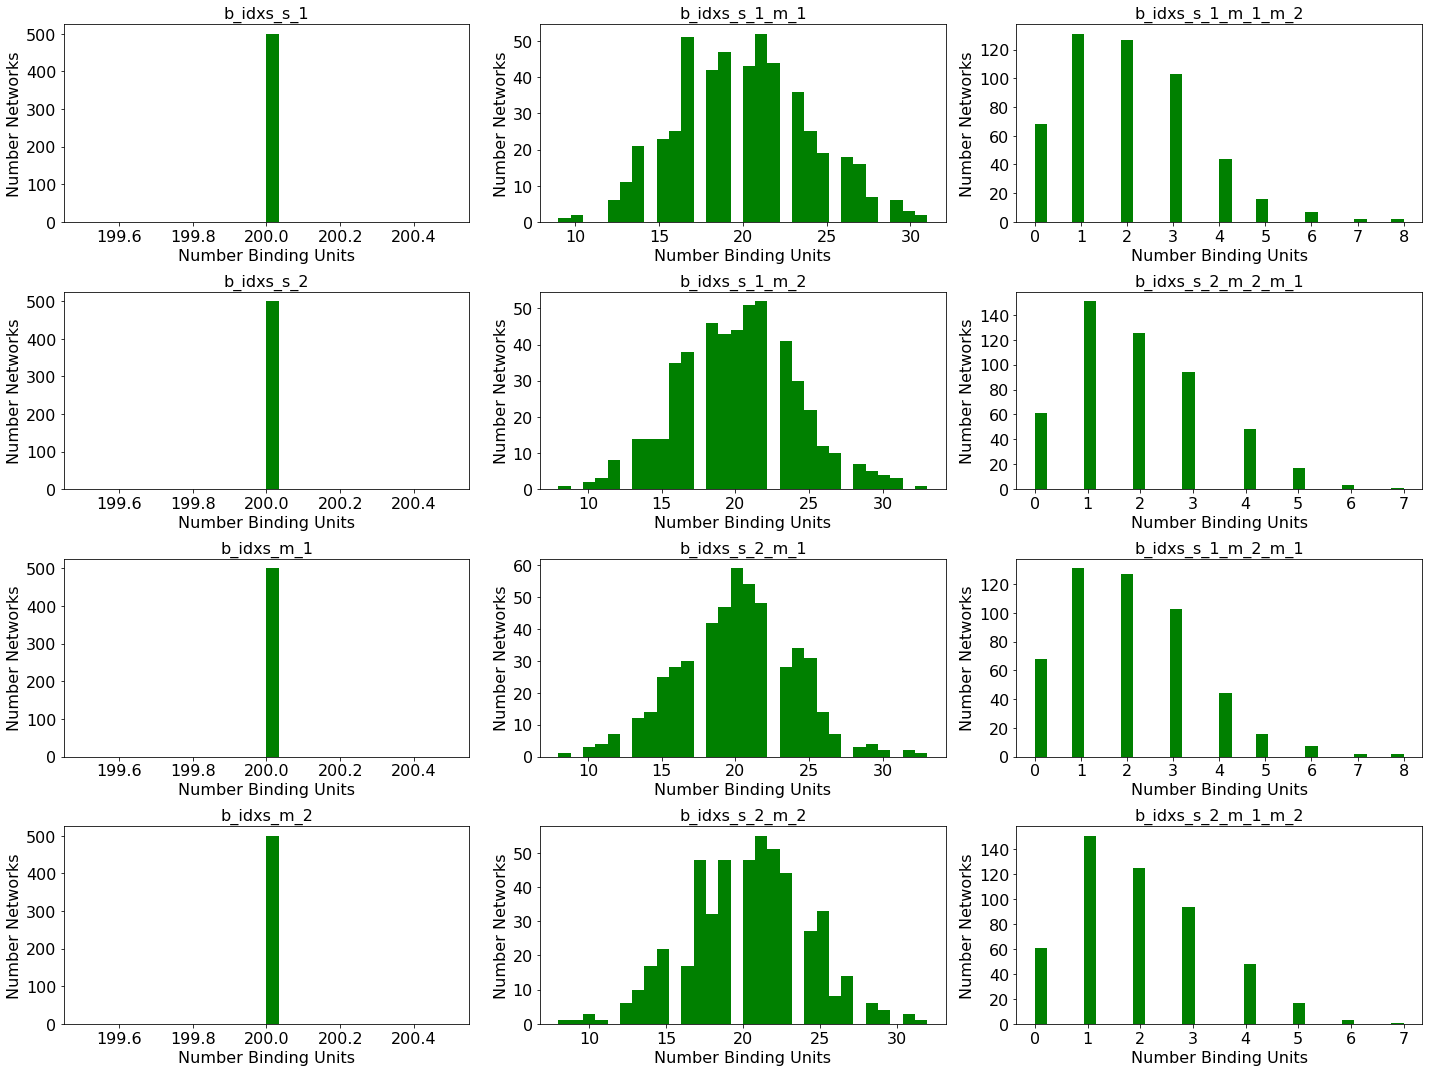

In [8]:
# loop over instantiations to get distribution of intersection sizes
b_idxs_sizes = {'n_{}'.format(k): [] for k in info if k.startswith('b_idx')}

for seed in range(500):
    # get size of intersections
    ntwk, info = make_ntwk(seed, 'S1->M2,S2->M1')
    for k in b_idxs_sizes:
        b_idxs_sizes[k].append(len(info[k[2:]]))
        
# plot histograms
order = [
    'b_idxs_s_1', 'b_idxs_s_2', 'b_idxs_m_1', 'b_idxs_m_2',  # should be ~Nq
    'b_idxs_s_1_m_1', 'b_idxs_s_1_m_2', 'b_idxs_s_2_m_1', 'b_idxs_s_2_m_2',  # should be ~Nq**2
    'b_idxs_s_1_m_1_m_2', 'b_idxs_s_2_m_2_m_1', 'b_idxs_s_1_m_2_m_1', 'b_idxs_s_2_m_1_m_2',  # should be ~Nq**3
]

fig, axs = plt.subplots(4, 3, figsize=(20, 15), tight_layout=True)
for k, ax in zip(order, axs.T.flatten()):
    ax.hist(b_idxs_sizes['n_{}'.format(k)], bins=30, color='g')
    ax.set_xlabel('Number Binding Units')
    ax.set_ylabel('Number Networks')
    ax.set_title(k)
    set_font_size(ax, 16)